#Fruits and vegetables

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/00. 2021-2/Simulación de sistemas y laboratorio/Proyecto/Base de datos/frtutasyverduras.zip", 'r')
zip_ref.extractall("/content/fyv")
zip_ref.close()

In [ ]:
labels = ["banana", "apple", "pear", "grapes", "orange", "kiwi", "watermelon", 
          "pomegranate", "pineapple", "mango","cucumber", "carrot", "capsicum", 
          "onion", "potato", "lemon", "tomato", "raddish", "beetroot", "cabbage", 
          "lettuce", "spinach", "soy beans", "cauliflower", "bell pepper", "chilli pepper", 
          "turnip", "corn", "sweetcorn", "sweet" "potato", "paprika", "jalepeno", 
          "ginger", "garlic", "peas", "eggplant"]

In [ ]:
for i in ['train','test','validation']:
  
  num_skipped = 0
  for folder_name in (labels):
      folder_path = os.path.join(("/content/fyv/"+i), folder_name)
      for fname in os.listdir(folder_path):
          fpath = os.path.join(folder_path, fname)
          try:
              fobj = open(fpath, "rb")
              is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
          finally:
              fobj.close()

          if not is_jfif:
              num_skipped += 1
              # Delete corrupted image
              os.remove(fpath)

  print("Deleted %d images" % num_skipped)


Deleted 644 images
Deleted 67 images
Deleted 67 images


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/train",
    image_size=(180,180),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb',
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/test",
    label_mode='categorical',
    color_mode='rgb',
    image_size=(180,180),
    batch_size=32,
)

Found 2471 files belonging to 36 classes.
Found 292 files belonging to 36 classes.


# Model FV

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model_fv= make_model(input_shape=(180,180) + (3,), num_classes=36)

model_fv.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("model_fv_{epoch}.h5"),
]
model_fv.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_fv= model_fv.fit(train_ds, 
                         epochs=epochs, 
                         callbacks=callbacks, 
                         validation_data=test_ds)

Epoch 1/50
78/78 [==============================] - 62s 505ms/step - loss: 0.1408 - accuracy: 0.1522 - val_loss: 0.3585 - val_accuracy: 0.0274
Epoch 2/50
78/78 [==============================] - 52s 613ms/step - loss: 0.1017 - accuracy: 0.2384 - val_loss: 0.1649 - val_accuracy: 0.0274
Epoch 3/50
78/78 [==============================] - 50s 591ms/step - loss: 0.0956 - accuracy: 0.2914 - val_loss: 0.1418 - val_accuracy: 0.0274
Epoch 4/50
78/78 [==============================] - 50s 590ms/step - loss: 0.0907 - accuracy: 0.3128 - val_loss: 0.1434 - val_accuracy: 0.0274
Epoch 5/50
78/78 [==============================] - 50s 587ms/step - loss: 0.0869 - accuracy: 0.3679 - val_loss: 0.1445 - val_accuracy: 0.0342
Epoch 6/50
78/78 [==============================] - 50s 593ms/step - loss: 0.0837 - accuracy: 0.3784 - val_loss: 0.1440 - val_accuracy: 0.0582
Epoch 7/50
78/78 [==============================] - 50s 593ms/step - loss: 0.0815 - accuracy: 0.3950 - val_loss: 0.0923 - val_accuracy: 0.2979

In [ ]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/validation/",
    labels='inferred',
    label_mode='categorical',
    image_size=(180,180))

predictions = np.array([])
labels_pred =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model_fv.predict(x), axis = -1)])
  labels_pred = np.concatenate([labels_pred, np.argmax(y.numpy(), axis=-1)])

Found 284 files belonging to 36 classes.


Confusion Matrix


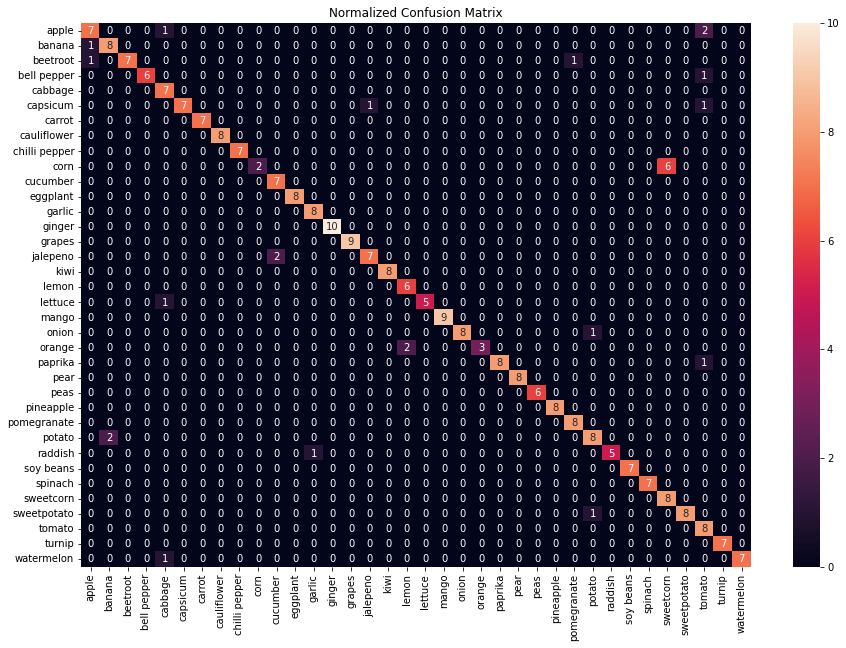

Classification Report
               precision    recall  f1-score   support

        apple       0.78      0.70      0.74        10
       banana       0.80      0.89      0.84         9
     beetroot       1.00      0.78      0.88         9
  bell pepper       1.00      0.86      0.92         7
      cabbage       0.70      1.00      0.82         7
     capsicum       1.00      0.78      0.88         9
       carrot       1.00      1.00      1.00         7
  cauliflower       1.00      1.00      1.00         8
chilli pepper       1.00      1.00      1.00         7
         corn       1.00      0.25      0.40         8
     cucumber       0.78      1.00      0.88         7
     eggplant       1.00      1.00      1.00         8
       garlic       0.89      1.00      0.94         8
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.88      0.78      0.82         9
         kiwi       1.00      1.00      1.

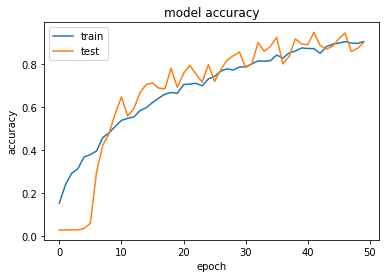

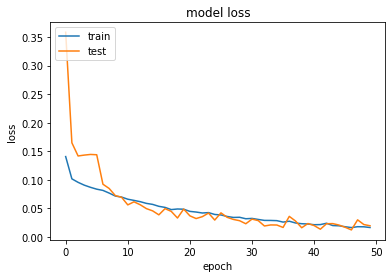

In [ ]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(labels_pred, predictions)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()
print('Classification Report')
target_names = sorted(labels)

print(classification_report(labels_pred, predictions, target_names=target_names))
print(history_fv.history.keys())

# summarize history for accuracy
plt.plot(history_fv.history['accuracy'])
plt.plot(history_fv.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fv.history['loss'])
plt.plot(history_fv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/fyv/validation/kiwi/Image_2.jpg", target_size=(180,180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_fv.predict(img_array)
print(predictions)
y_proba = np.argmax(predictions)
print(y_proba)
y_classes = sorted(set(labels))[y_proba]
print(y_classes)

[[6.8179967e-10 1.5440019e-11 1.3187411e-12 7.2132360e-15 2.1263734e-14
  1.2666497e-12 3.7915010e-18 7.7801637e-17 8.8314132e-13 1.4389964e-09
  1.8701514e-13 8.7140573e-12 1.7048698e-12 7.3747855e-13 1.3459043e-14
  2.9200864e-15 9.9999988e-01 3.0404080e-15 4.6950498e-15 1.1209957e-12
  4.7197593e-11 1.0218093e-17 2.3216164e-12 2.1802509e-11 1.4632222e-09
  2.3068369e-13 4.5706423e-14 2.6147159e-10 1.3079171e-16 7.6142953e-11
  7.5502137e-15 2.0041815e-12 8.3306273e-13 1.2845645e-07 1.8555634e-12
  2.4631288e-14]]
16
kiwi


#Others Models

## Model 1

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3,3), input_shape = (180,180,3), activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Conv2D(64, (3,3), activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))

model_1.add(layers.Flatten())

model_1.add(layers.Dense(units = 128, activation='relu'))
model_1.add(layers.Dense(units = 256, activation='relu'))
model_1.add(layers.Dense(units = 36, activation='softmax'))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 118336)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model_1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history_1 = model_1.fit(train_ds, 
                      epochs=epochs, 
                      callbacks=callbacks, 
                      validation_data=test_ds)

Epoch 1/10
78/78 [==============================] - 45s 518ms/step - loss: 103.3646 - accuracy: 0.0445 - val_loss: 3.5407 - val_accuracy: 0.1644
Epoch 2/10
78/78 [==============================] - 45s 531ms/step - loss: 3.3368 - accuracy: 0.1586 - val_loss: 2.4294 - val_accuracy: 0.4589
Epoch 3/10
78/78 [==============================] - 45s 521ms/step - loss: 2.4322 - accuracy: 0.3998 - val_loss: 1.3626 - val_accuracy: 0.7329
Epoch 4/10
78/78 [==============================] - 45s 520ms/step - loss: 1.4369 - accuracy: 0.6900 - val_loss: 1.1151 - val_accuracy: 0.8356
Epoch 5/10
78/78 [==============================] - 45s 521ms/step - loss: 0.7852 - accuracy: 0.8543 - val_loss: 0.8282 - val_accuracy: 0.8630
Epoch 6/10
78/78 [==============================] - 52s 619ms/step - loss: 0.5024 - accuracy: 0.9085 - val_loss: 0.4976 - val_accuracy: 0.9144
Epoch 7/10
78/78 [==============================] - 51s 609ms/step - loss: 0.3745 - accuracy: 0.9357 - val_loss: 0.5301 - val_accuracy: 0.92

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/validation/",
    labels='inferred',
    label_mode='categorical',
    image_size=(180,180))

Found 284 files belonging to 36 classes.


Confusion Matrix


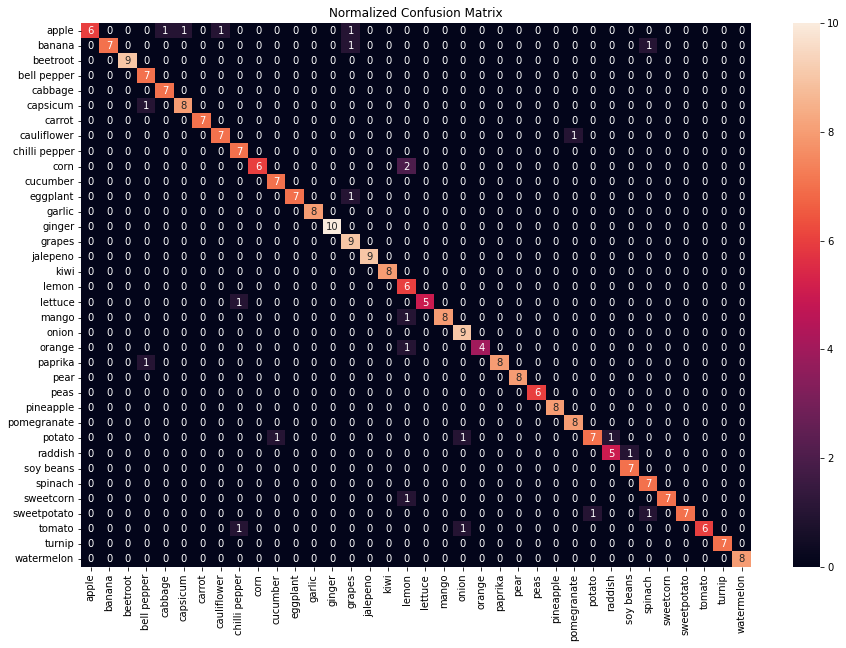

Classification Report
               precision    recall  f1-score   support

        apple       1.00      0.60      0.75        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00         9
  bell pepper       0.78      1.00      0.88         7
      cabbage       0.88      1.00      0.93         7
     capsicum       0.89      0.89      0.89         9
       carrot       1.00      1.00      1.00         7
  cauliflower       0.88      0.88      0.88         8
chilli pepper       0.78      1.00      0.88         7
         corn       1.00      0.75      0.86         8
     cucumber       0.88      1.00      0.93         7
     eggplant       1.00      0.88      0.93         8
       garlic       1.00      1.00      1.00         8
       ginger       1.00      1.00      1.00        10
       grapes       0.75      1.00      0.86         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00      1.

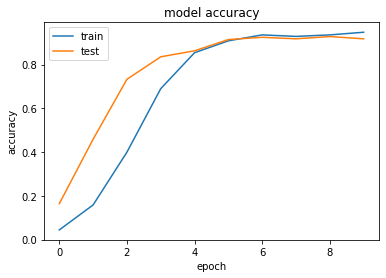

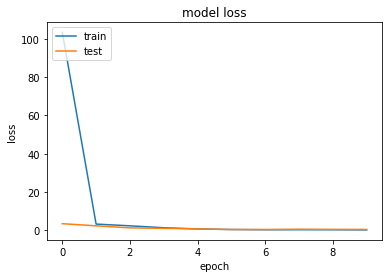

In [ ]:
predictions = np.array([])
labels_pred =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model_1.predict(x), axis = -1)])
  labels_pred = np.concatenate([labels_pred, np.argmax(y.numpy(), axis=-1)])

print('Confusion Matrix')
cf_matrix = confusion_matrix(labels_pred, predictions)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()
print('Classification Report')
target_names = sorted(labels)

print(classification_report(labels_pred, predictions, target_names=target_names))
print(history_1.history.keys())
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/fyv/validation/kiwi/Image_2.jpg", target_size=(180,180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_1.predict(img_array)
print(predictions)
y_proba = np.argmax(predictions)
print(y_proba)
y_classes = sorted(set(labels))[y_proba]
print(y_classes)

[[4.4991463e-12 2.7443176e-10 1.5474675e-11 3.3051171e-07 6.6788857e-08
  1.2665761e-08 3.7218453e-07 2.2010746e-10 5.3540088e-08 1.4997670e-09
  3.8772566e-08 1.7835159e-09 5.8348881e-09 5.9109150e-12 2.3463513e-09
  2.6369216e-09 9.9999893e-01 7.3462769e-10 9.3267123e-11 8.2583558e-12
  6.4365513e-11 1.2665947e-09 1.1776942e-10 2.0122368e-10 2.8022728e-11
  2.1266120e-09 1.1315420e-12 9.1118833e-13 6.4752594e-09 1.8008063e-08
  2.2728421e-10 1.9395095e-10 1.3980137e-09 2.9858102e-11 3.9244650e-08
  8.9908859e-08]]
16
kiwi


## Model 2

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3,3), input_shape = (180,180,3), activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))
model_2.add(layers.Dropout(0.2))

model_2.add(layers.Conv2D(64, (3,3), activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))
model_2.add(layers.Dropout(0.2))

model_2.add(layers.Flatten())

#model_1.add(layers.Dense(units = 128, activation='relu'))
#model_1.add(layers.Dense(units = 256, activation='relu'))
model_2.add(layers.Dense(units = 36, activation='softmax'))
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 43, 43, 64)       

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history_2 = model_2.fit(train_ds, 
                      epochs=epochs, 
                      callbacks=callbacks, 
                      validation_data=test_ds)

Epoch 1/10
78/78 [==============================] - 45s 516ms/step - loss: 186.3369 - accuracy: 0.0469 - val_loss: 3.5466 - val_accuracy: 0.1027
Epoch 2/10
78/78 [==============================] - 50s 561ms/step - loss: 3.1952 - accuracy: 0.1242 - val_loss: 3.2167 - val_accuracy: 0.2740
Epoch 3/10
78/78 [==============================] - 45s 521ms/step - loss: 2.7515 - accuracy: 0.2594 - val_loss: 2.6797 - val_accuracy: 0.4589
Epoch 4/10
78/78 [==============================] - 45s 530ms/step - loss: 2.1615 - accuracy: 0.4290 - val_loss: 2.1498 - val_accuracy: 0.5993
Epoch 5/10
78/78 [==============================] - 45s 521ms/step - loss: 1.6692 - accuracy: 0.5763 - val_loss: 1.5953 - val_accuracy: 0.7466
Epoch 6/10
78/78 [==============================] - 44s 515ms/step - loss: 1.2061 - accuracy: 0.7030 - val_loss: 1.3757 - val_accuracy: 0.8048
Epoch 7/10
78/78 [==============================] - 44s 514ms/step - loss: 0.8852 - accuracy: 0.7709 - val_loss: 1.6189 - val_accuracy: 0.85

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/validation/",
    labels='inferred',
    label_mode='categorical',
    image_size=(180,180))

Found 284 files belonging to 36 classes.


Confusion Matrix


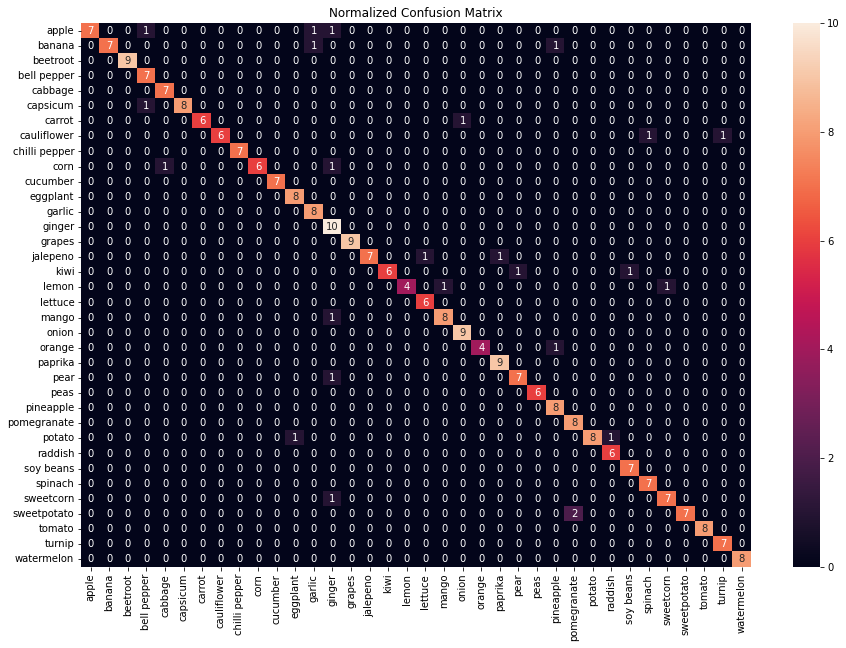

Classification Report
               precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00         9
  bell pepper       0.78      1.00      0.88         7
      cabbage       0.88      1.00      0.93         7
     capsicum       1.00      0.89      0.94         9
       carrot       1.00      0.86      0.92         7
  cauliflower       1.00      0.75      0.86         8
chilli pepper       1.00      1.00      1.00         7
         corn       1.00      0.75      0.86         8
     cucumber       1.00      1.00      1.00         7
     eggplant       0.89      1.00      0.94         8
       garlic       0.80      1.00      0.89         8
       ginger       0.67      1.00      0.80        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      0.78      0.88         9
         kiwi       1.00      0.75      0.

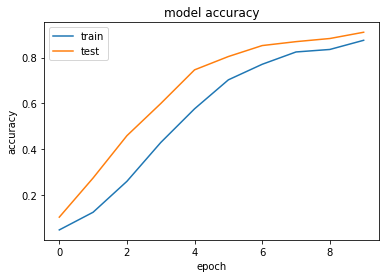

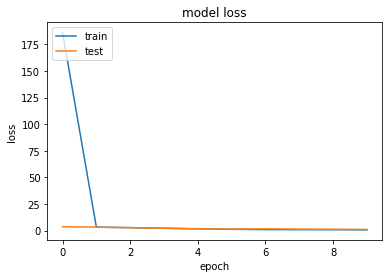

In [ ]:
predictions = np.array([])
labels_pred =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model_2.predict(x), axis = -1)])
  labels_pred = np.concatenate([labels_pred, np.argmax(y.numpy(), axis=-1)])

print('Confusion Matrix')
cf_matrix = confusion_matrix(labels_pred, predictions)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()
print('Classification Report')
target_names = sorted(labels)

print(classification_report(labels_pred, predictions, target_names=target_names))
print(history_2.history.keys())
# summarize history for accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/fyv/validation/kiwi/Image_2.jpg", target_size=(180,180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_2.predict(img_array)
print(predictions)
y_proba = np.argmax(predictions)
print(y_proba)
y_classes = sorted(set(labels))[y_proba]
print(y_classes)

[[8.96686339e-04 3.43417807e-04 1.16440729e-04 5.71595505e-04
  3.11596697e-04 2.37509201e-04 6.05091336e-04 6.85397419e-04
  2.82655004e-04 1.17231905e-03 6.42544124e-04 1.79270399e-03
  4.33865614e-04 1.13484544e-04 1.83939046e-04 2.45521980e-04
  9.66806412e-01 2.00090627e-03 9.17314377e-04 6.68401830e-04
  9.26728128e-04 7.04296181e-05 1.07988995e-03 2.20032030e-04
  1.25690061e-03 4.12237365e-03 1.24645524e-03 1.89364786e-04
  1.80188427e-03 4.05700877e-04 1.32915462e-04 1.97576184e-04
  2.24654923e-05 7.53250089e-04 6.62122853e-03 1.92488520e-03]]
16
kiwi


## Model 3

In [ ]:
model_3 = models.Sequential()
# convolutional layer
model_3.add(layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(180, 180, 3)))

# convolutional layer
model_3.add(layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.25))

model_3.add(layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=(2,2)))
model_3.add(layers.Dropout(0.25))

# flatten output of conv
model_3.add(layers.Flatten())

# output layer
model_3.add(layers.Dense(units = 36, activation='softmax'))
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 45, 45, 128)      0         
 g2D)                                                 

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history_3 = model_3.fit(train_ds, 
                      epochs=epochs, 
                      callbacks=callbacks, 
                      validation_data=test_ds)

Epoch 1/10
78/78 [==============================] - 57s 655ms/step - loss: 181.1742 - accuracy: 0.0271 - val_loss: 3.5820 - val_accuracy: 0.0411
Epoch 2/10
78/78 [==============================] - 64s 767ms/step - loss: 3.5754 - accuracy: 0.0356 - val_loss: 3.5630 - val_accuracy: 0.0514
Epoch 3/10
78/78 [==============================] - 52s 601ms/step - loss: 3.5510 - accuracy: 0.0453 - val_loss: 3.5040 - val_accuracy: 0.0753
Epoch 4/10
78/78 [==============================] - 46s 539ms/step - loss: 3.4822 - accuracy: 0.0822 - val_loss: 3.3038 - val_accuracy: 0.1473
Epoch 5/10
78/78 [==============================] - 46s 539ms/step - loss: 3.2854 - accuracy: 0.1364 - val_loss: 3.0821 - val_accuracy: 0.2671
Epoch 6/10
78/78 [==============================] - 46s 537ms/step - loss: 3.0983 - accuracy: 0.1947 - val_loss: 2.7860 - val_accuracy: 0.3356
Epoch 7/10
78/78 [==============================] - 46s 538ms/step - loss: 2.8631 - accuracy: 0.2517 - val_loss: 2.7704 - val_accuracy: 0.36

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/validation/",
    labels='inferred',
    label_mode='categorical',
    image_size=(180,180))

Found 284 files belonging to 36 classes.


Confusion Matrix


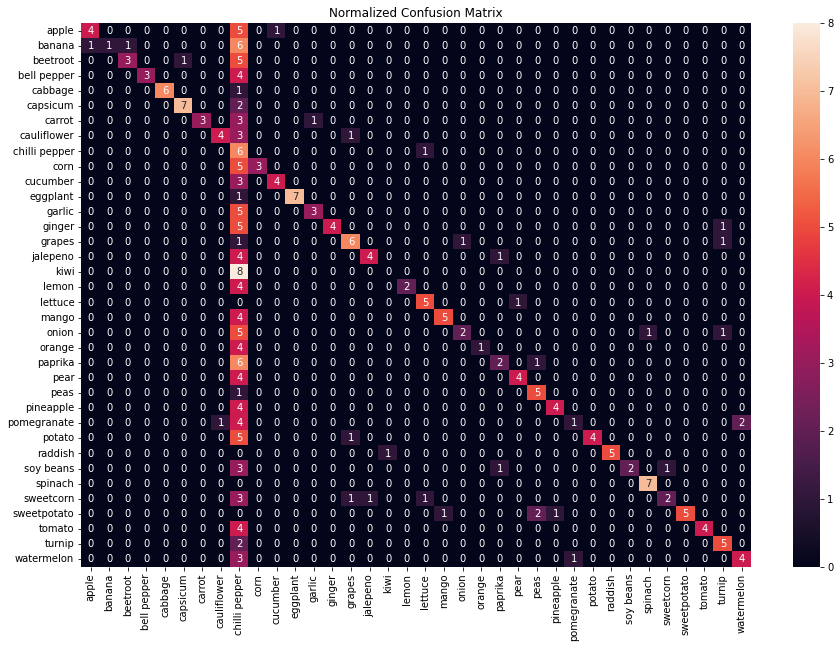

Classification Report
               precision    recall  f1-score   support

        apple       0.80      0.40      0.53        10
       banana       1.00      0.11      0.20         9
     beetroot       0.75      0.33      0.46         9
  bell pepper       1.00      0.43      0.60         7
      cabbage       1.00      0.86      0.92         7
     capsicum       0.88      0.78      0.82         9
       carrot       1.00      0.43      0.60         7
  cauliflower       0.80      0.50      0.62         8
chilli pepper       0.05      0.86      0.09         7
         corn       1.00      0.38      0.55         8
     cucumber       0.80      0.57      0.67         7
     eggplant       1.00      0.88      0.93         8
       garlic       0.75      0.38      0.50         8
       ginger       1.00      0.40      0.57        10
       grapes       0.67      0.67      0.67         9
     jalepeno       0.80      0.44      0.57         9
         kiwi       0.00      0.00      0.

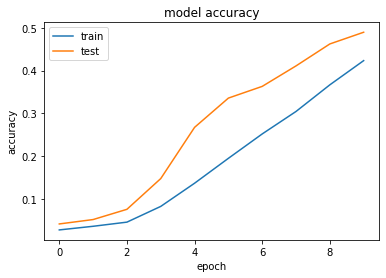

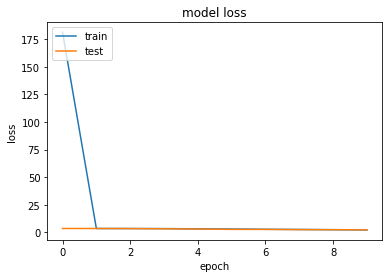

In [ ]:
predictions = np.array([])
labels_pred =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model_3.predict(x), axis = -1)])
  labels_pred = np.concatenate([labels_pred, np.argmax(y.numpy(), axis=-1)])

print('Confusion Matrix')
cf_matrix = confusion_matrix(labels_pred, predictions)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()
print('Classification Report')
target_names = sorted(labels)

print(classification_report(labels_pred, predictions, target_names=target_names))
print(history_3.history.keys())
# summarize history for accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/fyv/validation/kiwi/Image_2.jpg", target_size=(180,180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_3.predict(img_array)
print(predictions)
y_proba = np.argmax(predictions)
print(y_proba)
y_classes = sorted(set(labels))[y_proba]
print(y_classes)

[[0.02464494 0.02761254 0.02614938 0.0292522  0.0279831  0.02889434
  0.0301082  0.02455377 0.03157625 0.02668513 0.02763044 0.02489145
  0.02768165 0.02720386 0.03016633 0.02752204 0.0310696  0.02697281
  0.02775556 0.02756486 0.02930982 0.02432092 0.03132129 0.02639059
  0.02834148 0.02812981 0.02781637 0.02711661 0.02737028 0.03144517
  0.02585724 0.02863399 0.02371956 0.02979965 0.02724542 0.02726341]]
8
chilli pepper


## Model 4

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
inputs = keras.Input(shape=(180,180,3))
# Image augmentation block
x = data_augmentation(inputs)

# Entry block
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same", activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same", activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)


x = layers.Conv2D(128, 3, strides=2, padding="same", activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

outputs = layers.Dense(units = 36, activation='softmax')(x)

model_4 = keras.Model(inputs, outputs)

model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 45, 45, 32)       128       
 chNormalization)                                          

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model_4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history_4 = model_4.fit(train_ds, 
                      epochs=epochs, 
                      callbacks=callbacks, 
                      validation_data=test_ds)

Epoch 1/30
78/78 [==============================] - 51s 595ms/step - loss: 3.3542 - accuracy: 0.1429 - val_loss: 3.8924 - val_accuracy: 0.0308
Epoch 2/30
78/78 [==============================] - 41s 475ms/step - loss: 2.6867 - accuracy: 0.2562 - val_loss: 4.3246 - val_accuracy: 0.0616
Epoch 3/30
78/78 [==============================] - 41s 476ms/step - loss: 2.3768 - accuracy: 0.3177 - val_loss: 4.1847 - val_accuracy: 0.0719
Epoch 4/30
78/78 [==============================] - 41s 474ms/step - loss: 2.2009 - accuracy: 0.3634 - val_loss: 3.5633 - val_accuracy: 0.1370
Epoch 5/30
78/78 [==============================] - 40s 470ms/step - loss: 2.1110 - accuracy: 0.3946 - val_loss: 2.7996 - val_accuracy: 0.2260
Epoch 6/30
78/78 [==============================] - 41s 474ms/step - loss: 1.9614 - accuracy: 0.4253 - val_loss: 2.0271 - val_accuracy: 0.3938
Epoch 7/30
78/78 [==============================] - 41s 473ms/step - loss: 1.8568 - accuracy: 0.4484 - val_loss: 1.5465 - val_accuracy: 0.5000

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/fyv/validation/",
    labels='inferred',
    label_mode='categorical',
    image_size=(180,180))

Found 284 files belonging to 36 classes.


Confusion Matrix


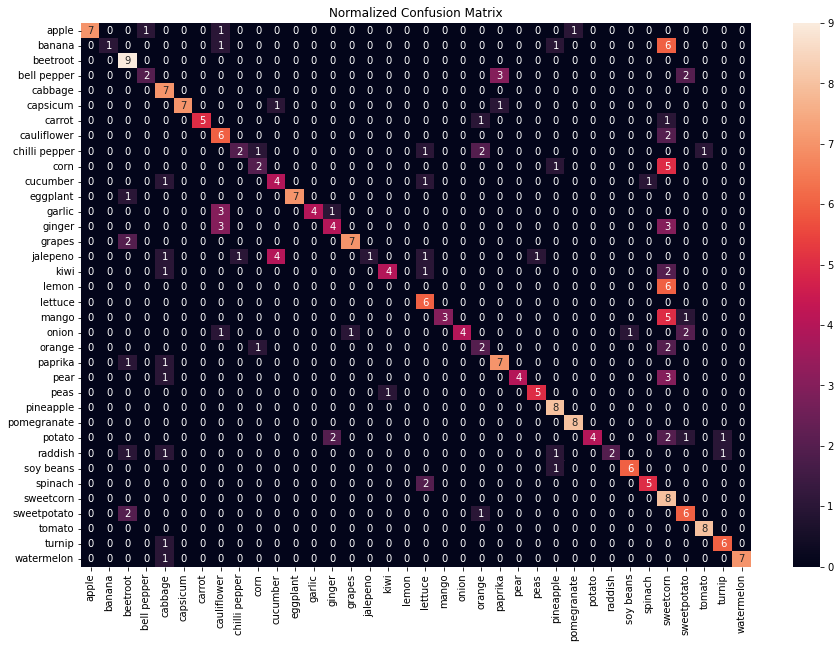

Classification Report
               precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       1.00      0.11      0.20         9
     beetroot       0.56      1.00      0.72         9
  bell pepper       0.67      0.29      0.40         7
      cabbage       0.47      1.00      0.64         7
     capsicum       1.00      0.78      0.88         9
       carrot       1.00      0.71      0.83         7
  cauliflower       0.40      0.75      0.52         8
chilli pepper       0.67      0.29      0.40         7
         corn       0.50      0.25      0.33         8
     cucumber       0.44      0.57      0.50         7
     eggplant       1.00      0.88      0.93         8
       garlic       1.00      0.50      0.67         8
       ginger       0.57      0.40      0.47        10
       grapes       0.88      0.78      0.82         9
     jalepeno       1.00      0.11      0.20         9
         kiwi       0.80      0.50      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


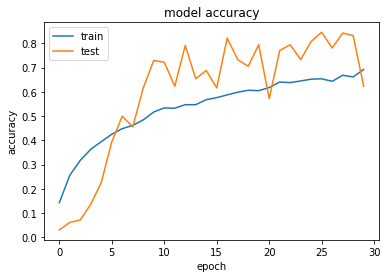

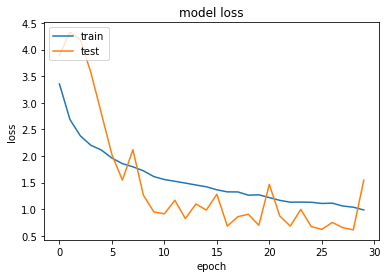

In [ ]:
predictions = np.array([])
labels_pred =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model_4.predict(x), axis = -1)])
  labels_pred = np.concatenate([labels_pred, np.argmax(y.numpy(), axis=-1)])

print('Confusion Matrix')
cf_matrix = confusion_matrix(labels_pred, predictions)
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(labels)), 
            yticklabels = sorted(set(labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()
print('Classification Report')
target_names = sorted(labels)

print(classification_report(labels_pred, predictions, target_names=target_names))
print(history_4.history.keys())
# summarize history for accuracy
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/fyv/validation/kiwi/Image_2.jpg", target_size=(180,180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_4.predict(img_array)
print(predictions)
y_proba = np.argmax(predictions)
print(y_proba)
y_classes = sorted(set(labels))[y_proba]
print(y_classes)

[[3.4435489e-04 1.3611891e-03 3.7749199e-04 8.7494933e-05 4.6846626e-04
  1.4558992e-05 4.0727845e-04 6.2316387e-05 1.7604850e-04 2.6107205e-02
  4.5374702e-03 2.2558407e-04 5.8303704e-05 1.4244950e-04 8.4914762e-04
  8.2022198e-06 5.7516950e-01 8.4750682e-05 2.5287735e-01 1.7752076e-03
  8.1399776e-05 1.5402311e-05 2.1975728e-05 2.2495624e-04 1.6226217e-02
  8.4410579e-04 1.9486218e-04 2.3758254e-04 1.7479823e-03 1.9691763e-02
  3.4049287e-02 1.1601506e-02 1.7333897e-06 6.6625001e-04 9.6715344e-03
  3.9589047e-02]]
16
kiwi
